In [ ]:
# Extract the folders from Zipped file
!unzip /content/drive/MyDrive/CNN/Dataset.zip -d /content/drive/MyDrive/CNN/Dataset/

Archive:  /content/drive/MyDrive/CNN/Dataset.zip
replace /content/drive/MyDrive/CNN/Dataset/images.cv_jzk6llhf18tm3k0kyttxz/readme.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/drive/MyDrive/CNN/Dataset/images.cv_jzk6llhf18tm3k0kyttxz/readme.txt  
replace /content/drive/MyDrive/CNN/Dataset/images.cv_jzk6llhf18tm3k0kyttxz/data/test/fish sea_food black_sea_sprat/2EBY9T7TKTBH.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
# Read dataset
val_data = "/content/drive/MyDrive/CNN/Dataset/images.cv_jzk6llhf18tm3k0kyttxz/data/val"
train_data = "/content/drive/MyDrive/CNN/Dataset/images.cv_jzk6llhf18tm3k0kyttxz/data/train"
test_data = "/content/drive/MyDrive/CNN/Dataset/images.cv_jzk6llhf18tm3k0kyttxz/data/test"

In [3]:
!pip install tensorflow

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Resize for validation
val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale
val_generator = val_datagen.flow_from_directory(
    val_data,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Resize for test data
test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale
test_generator = test_datagen.flow_from_directory(
    test_data,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Apply augumentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0,1]
    rotation_range=40,  # Random rotation
    width_shift_range=0.2,  # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True  # Flip images
)
train_generator = train_datagen.flow_from_directory(
    train_data,
    target_size=(224, 224),  # Resize all images
    batch_size=32,
    class_mode='categorical'
)

Found 1092 images belonging to 11 classes.
Found 3187 images belonging to 11 classes.
Found 6225 images belonging to 11 classes.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the CNN model
model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')  # 10 classes for classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,626,442 (6.20 MB)

 Trainable params: 1,626,442 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
import pickle

# Define save path
save_path = "/content/drive/MyDrive/CNN_F"

# Load the pre-trained VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the convolutional layers

# Add custom classification layers
x = Flatten()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dense(train_generator.num_classes, activation="softmax")(x)  # Use number of classes from augmented data

model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Train the model using augmented dataset
history = model.fit(train_generator, validation_data=val_generator, epochs=3)

# Save the trained model
model.save(f"{save_path}/vgg16_trained_model.h5")
print(f"Model saved successfully at {save_path}/vgg16_trained_model.h5")

# Save training history
with open(f"{save_path}/training_history_vgg16.pkl", "wb") as f:
    pickle.dump(history.history, f)
print(f"Training history saved successfully at {save_path}/training_history_vgg16.pkl")

# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f}")


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
195/195 ━━━━━━━━━━━━━━━━━━━━ 2418s 12s/step - accuracy: 0.4774 - loss: 2.4319 - val_accuracy: 0.8956 - val_loss: 0.3630
Epoch 2/3
195/195 ━━━━━━━━━━━━━━━━━━━━ 103s 529ms/step - accuracy: 0.8637 - loss: 0.4450 - val_accuracy: 0.9469 - val_loss: 0.2065
Epoch 3/3
195/195 ━━━━━━━━━━━━━━━━━━━━ 103s 526ms/step - accuracy: 0.9180 - loss: 0.2766 - val_accuracy: 0.9405 - val_loss: 0.1935


Model saved successfully at /content/drive/MyDrive/CNN_F/vgg16_trained_model.h5
Training history saved successfully at /content/drive/MyDrive/CNN_F/training_history_vgg16.pkl
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 160ms/step - accuracy: 0.9413 - loss: 0.1718
Test accuracy: 0.9429


In [ ]:
""" Reload the saved model if required
loaded_model = load_model("vgg16_trained_model.h5")
print("Model loaded successfully!")

# Evaluate the reloaded model (Optional)
test_loss, test_acc = loaded_model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f}")"""

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
import pickle

# Define save path
save_path = "/content/drive/MyDrive/CNN_F"

# Load the pre-trained ResNet50 model
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the convolutional layers

# Add custom classification layers
x = Flatten()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dense(train_generator.num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Train the model
history = model.fit(train_generator, validation_data=val_generator, epochs=3)

# Save model
model.save(f"{save_path}/resnet50_trained_model.h5")
print(f"Model saved successfully at {save_path}/resnet50_trained_model.h5")

# Save training history
with open(f"{save_path}/training_history_resnet50.pkl", "wb") as f:
    pickle.dump(history.history, f)
print(f"Training history saved successfully at {save_path}/training_history_resnet50.pkl")

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f}")


In [ ]:
import tensorflow as tf
import pickle

# Define save path
save_path = "/content/drive/MyDrive/CNN_F"

# Load the trained model
model = tf.keras.models.load_model(f"{save_path}/resnet50_trained_model.h5")
print("Model loaded successfully!")

# Load training history
with open(f"{save_path}/training_history_resnet50.pkl", "rb") as f:
    history = pickle.load(f)
print("Training history loaded successfully!")

# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f}")


Model loaded successfully!
Training history loaded successfully!
100/100 ━━━━━━━━━━━━━━━━━━━━ 1904s 19s/step - accuracy: 0.3345 - loss: 1.8519
Test accuracy: 0.3210


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
import pickle

# Define save path
save_path = "/content/drive/MyDrive/CNN_F"

# Load the pre-trained MobileNet model
base_model = MobileNet(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the convolutional layers

# Add custom classification layers
x = Flatten()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dense(train_generator.num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Train the model
history = model.fit(train_generator, validation_data=val_generator, epochs=3)

# Save model
model.save(f"{save_path}/mobilenet_trained_model.h5")
print(f"Model saved successfully at {save_path}/mobilenet_trained_model.h5")

# Save training history
with open(f"{save_path}/training_history_mobilenet.pkl", "wb") as f:
    pickle.dump(history.history, f)
print(f"Training history saved successfully at {save_path}/training_history_mobilenet.pkl")

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f}")


Epoch 1/3
195/195 ━━━━━━━━━━━━━━━━━━━━ 4390s 23s/step - accuracy: 0.6668 - loss: 6.7062 - val_accuracy: 0.9588 - val_loss: 0.1462
Epoch 2/3
195/195 ━━━━━━━━━━━━━━━━━━━━ 542s 3s/step - accuracy: 0.9467 - loss: 0.1953 - val_accuracy: 0.9615 - val_loss: 0.1568
Epoch 3/3
195/195 ━━━━━━━━━━━━━━━━━━━━ 558s 3s/step - accuracy: 0.9607 - loss: 0.1652 - val_accuracy: 0.9863 - val_loss: 0.0503


Model saved successfully at /content/drive/MyDrive/CNN_F/mobilenet_trained_model.h5
Training history saved successfully at /content/drive/MyDrive/CNN_F/training_history_mobilenet.pkl
100/100 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.9854 - loss: 0.0471
Test accuracy: 0.9853


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
import pickle

# Define save path
save_path = "/content/drive/MyDrive/CNN_F"

# Load the pre-trained InceptionV3 model
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the convolutional layers

# Add custom classification layers
x = Flatten()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dense(train_generator.num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Train the model
history = model.fit(train_generator, validation_data=val_generator, epochs=3)

# Save model
model.save(f"{save_path}/inceptionv3_trained_model.h5")
print(f"Model saved successfully at {save_path}/inceptionv3_trained_model.h5")

# Save training history
with open(f"{save_path}/training_history_inceptionv3.pkl", "wb") as f:
    pickle.dump(history.history, f)
print(f"Training history saved successfully at {save_path}/training_history_inceptionv3.pkl")

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f}")


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/3
195/195 ━━━━━━━━━━━━━━━━━━━━ 1217s 6s/step - accuracy: 0.5881 - loss: 9.0180 - val_accuracy: 0.9038 - val_loss: 0.3526
Epoch 2/3
195/195 ━━━━━━━━━━━━━━━━━━━━ 1197s 6s/step - accuracy: 0.8772 - loss: 0.4172 - val_accuracy: 0.9267 - val_loss: 0.2547
Epoch 3/3
195/195 ━━━━━━━━━━━━━━━━━━━━ 1221s 6s/step - accuracy: 0.9032 - loss: 0.3155 - val_accuracy: 0.9487 - val_loss: 0.1685


Model saved successfully at /content/drive/MyDrive/CNN_F/inceptionv3_trained_model.h5
Training history saved successfully at /content/drive/MyDrive/CNN_F/training_history_inceptionv3.pkl
100/100 ━━━━━━━━━━━━━━━━━━━━ 484s 5s/step - accuracy: 0.9515 - loss: 0.1623
Test accuracy: 0.9517


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
import pickle

# Define save path
save_path = "/content/drive/MyDrive/CNN_F"

# Load the pre-trained EfficientNetB0 model
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the convolutional layers

# Add custom classification layers
x = Flatten()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dense(train_generator.num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Train the model
history = model.fit(train_generator, validation_data=val_generator, epochs=3)

# Save model
model.save(f"{save_path}/efficientnetb0_trained_model.h5")
print(f"Model saved successfully at {save_path}/efficientnetb0_trained_model.h5")

# Save training history
with open(f"{save_path}/training_history_efficientnetb0.pkl", "wb") as f:
    pickle.dump(history.history, f)
print(f"Training history saved successfully at {save_path}/training_history_efficientnetb0.pkl")

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f}")


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/3
195/195 ━━━━━━━━━━━━━━━━━━━━ 850s 4s/step - accuracy: 0.1138 - loss: 9.2043 - val_accuracy: 0.0943 - val_loss: 2.5935
Epoch 2/3
195/195 ━━━━━━━━━━━━━━━━━━━━ 838s 4s/step - accuracy: 0.1319 - loss: 2.5876 - val_accuracy: 0.0861 - val_loss: 2.4410
Epoch 3/3
195/195 ━━━━━━━━━━━━━━━━━━━━ 851s 4s/step - accuracy: 0.1387 - loss: 2.3832 - val_accuracy: 0.1712 - val_loss: 2.3655


Model saved successfully at /content/drive/MyDrive/CNN_F/efficientnetb0_trained_model.h5
Training history saved successfully at /content/drive/MyDrive/CNN_F/training_history_efficientnetb0.pkl
100/100 ━━━━━━━━━━━━━━━━━━━━ 295s 3s/step - accuracy: 0.1616 - loss: 2.3652
Test accuracy: 0.1632


100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 166ms/step - accuracy: 0.9452 - loss: 0.1664
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 171ms/step


100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - accuracy: 0.3216 - loss: 1.8622
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 167ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 143ms/step - accuracy: 0.9870 - loss: 0.0508
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 143ms/step


100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 161ms/step - accuracy: 0.9498 - loss: 0.1538
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 182ms/step


100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 176ms/step - accuracy: 0.1688 - loss: 2.3641
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 184ms/step

Model: VGG16
Accuracy: 0.9429
Precision: 0.1088
Recall: 0.1101
F1-Score: 0.1090
Confusion Matrix:
[[90  1 40 54 42 48 41 58 50 51 45]
 [ 1  0  0  0  2  1  2  1  5  0  1]
 [60  0 24 32 20 26 20 31 22 39 24]
 [50  0 20 32 29 18 22 29 27 56 22]
 [42  0 20 26 20 21 25 37 26 40 29]
 [56  0 23 36 16 21 20 39 24 30 26]
 [37  1 28 13 28 29 27 28 23 39 20]
 [63  0 26 31 24 21 33 33 28 40 28]
 [40  0 26 33 32 19 25 21 23 43 27]
 [49  0 18 16 19 27 28 40 19 46 31]
 [39  0 21 28 28 24 24 27 32 34 35]]

Model: ResNet50
Accuracy: 0.3210
Precision: 0.1433
Recall: 0.1302
F1-Score: 0.0818
Confusion Matrix:
[[228   0   2   0  26 118   0  11  19   0 116]
 [  3   0   0   0   1   7   0   0   1   0   1]
 [138   0   1   0   7  72   1   7  11   0  61]
 [141   0   0   0  17  66   0  11  11   0  59]
 [129   0   3   0  13  68   0   5   9   0  59]
 [115   0   0   1  14  80   0   5  10   0  66

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


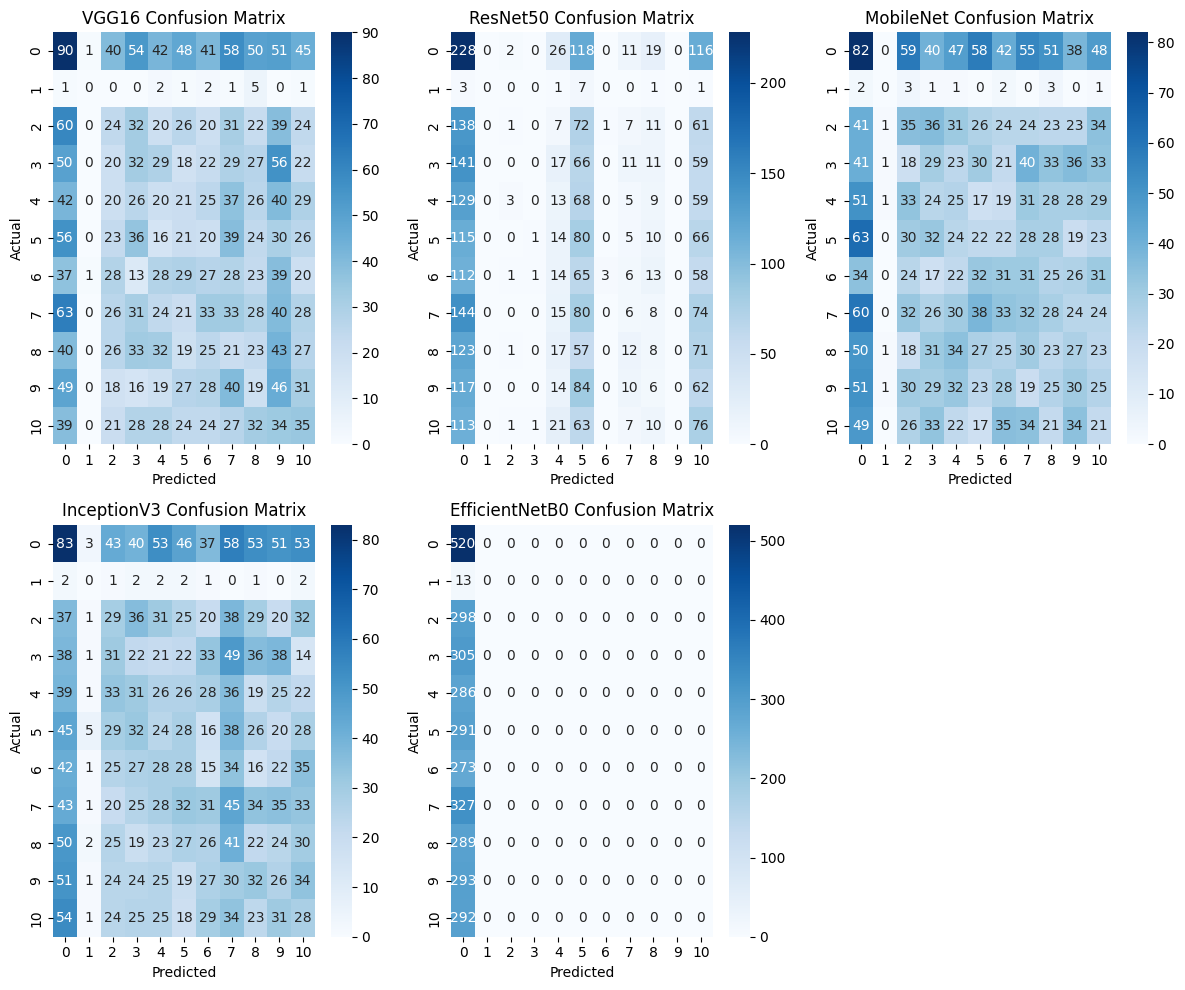

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Dictionary of models
models = {
    "VGG16": "/content/drive/MyDrive/CNN_F/vgg16_trained_model.h5",
    "ResNet50": "/content/drive/MyDrive/CNN_F/resnet50_trained_model.h5",
    "MobileNet": "/content/drive/MyDrive/CNN_F/mobilenet_trained_model.h5",
    "InceptionV3": "/content/drive/MyDrive/CNN_F/inceptionv3_trained_model.h5",
    "EfficientNetB0": "/content/drive/MyDrive/CNN_F/efficientnetb0_trained_model.h5",
}

# Store results
metrics = {}

for model_name, model_path in models.items():
    # Load model
    model = tf.keras.models.load_model(model_path)

    # Evaluate model on test data
    loss, acc = model.evaluate(test_generator)

    # Predict on test data
    y_pred_probs = model.predict(test_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = test_generator.classes  # Get true labels from the generator

    # Compute metrics
    precision = precision_score(y_true, y_pred, average="weighted")
    recall = recall_score(y_true, y_pred, average="weighted")
    f1 = f1_score(y_true, y_pred, average="weighted")
    cm = confusion_matrix(y_true, y_pred)

    # Store results
    metrics[model_name] = {
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "Confusion Matrix": cm
    }

# Display results
for model, scores in metrics.items():
    print(f"\nModel: {model}")
    for metric, value in scores.items():
        if metric == "Confusion Matrix":
            print(f"{metric}:\n{value}")
        else:
            print(f"{metric}: {value:.4f}")

# Plot Confusion Matrices
plt.figure(figsize=(12, 10))
for i, (model, scores) in enumerate(metrics.items()):
    plt.subplot(2, 3, i + 1)
    sns.heatmap(scores["Confusion Matrix"], annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

plt.tight_layout()
plt.show()


In [7]:
# Identify the best model based on Accuracy
best_model = max(metrics.items(), key=lambda x: x[1]["Accuracy"])

# Print the best model in the next cell
print(f"\nBest Model: {best_model[0]}")
print(f"Accuracy: {best_model[1]['Accuracy']:.4f}")
print(f"Precision: {best_model[1]['Precision']:.4f}")
print(f"Recall: {best_model[1]['Recall']:.4f}")
print(f"F1-Score: {best_model[1]['F1-Score']:.4f}")


Best Model: MobileNet
Accuracy: 0.9853
Precision: 0.1032
Recall: 0.1035
F1-Score: 0.1033


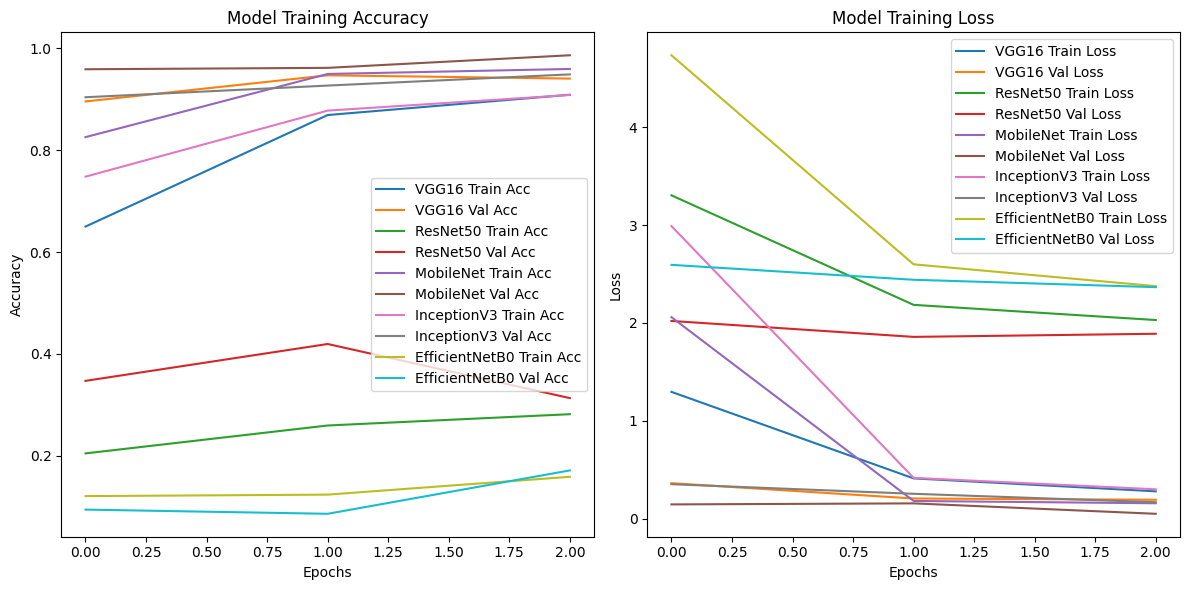

In [8]:
import pickle
import matplotlib.pyplot as plt

# List of model names and corresponding files
model_files = {
    "VGG16": "/content/drive/MyDrive/CNN_F/training_history_vgg16.pkl",
    "ResNet50": "/content/drive/MyDrive/CNN_F/training_history_resnet50.pkl",
    "MobileNet": "/content/drive/MyDrive/CNN_F/training_history_mobilenet.pkl",
    "InceptionV3": "/content/drive/MyDrive/CNN_F/training_history_inceptionv3.pkl",
    "EfficientNetB0": "/content/drive/MyDrive/CNN_F/training_history_efficientnetb0.pkl"
}

# Function to load history
def load_history(file):
    with open(file, 'rb') as f:
        return pickle.load(f)

# Plot training history
plt.figure(figsize=(12, 6))
for model, file in model_files.items():
    history = load_history(file)

    # Extract accuracy and loss
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    train_loss = history['loss']
    val_loss = history['val_loss']

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(train_acc, label=f"{model} Train Acc")
    plt.plot(val_acc, label=f"{model} Val Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Model Training Accuracy")
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label=f"{model} Train Loss")
    plt.plot(val_loss, label=f"{model} Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Model Training Loss")
    plt.legend()

# Show plots
plt.tight_layout()
plt.show()
